# Classification foliar diseases in apple trees

## Import Packages

In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.metrics import Precision, Recall
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import xgboost as xgb
import seaborn as sns
import cv2
import pathlib
import os

## Preprocessing Dataset Images

In [5]:
dataset_folder = os.path.join("/kaggle/input/plant-pathology-2020-fgvc7")

In [6]:
datasetObject = pd.read_csv(os.path.join(dataset_folder, "train.csv"))
datasetObject.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [7]:
imagesDataset = pathlib.Path(os.path.join(dataset_folder, "images"))
listImages = list(imagesDataset.glob("*.*"))

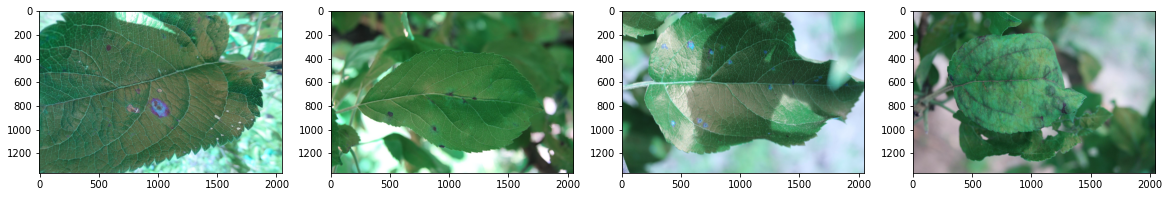

In [8]:
plt.figure(figsize = (20, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    img = cv2.imread(str(listImages[i]))
    plt.imshow(img)
plt.show()

In [9]:
images_id_csv = datasetObject['image_id']
healthy_csv = datasetObject['healthy']
multiple_diseases_csv = datasetObject['multiple_diseases']
rust_csv = datasetObject['rust']
scab_csv = datasetObject['scab']

In [10]:
images = []
labels = []
for index, values in enumerate(images_id_csv):
    img = cv2.imread(os.path.join(dataset_folder, "images", "{}.jpg".format(values)))
    img = cv2.resize(img, (100, 100))
    img = img/255
    labels.append([healthy_csv[index], multiple_diseases_csv[index], rust_csv[index],
                 scab_csv[index]])
    images.append(img)

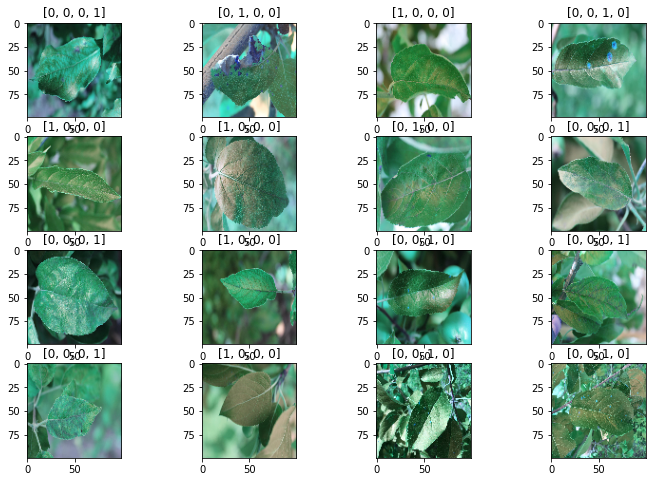

In [11]:
plt.figure(figsize = (12, 8))
for i in range(16):
  plt.subplot(4, 4, i + 1)
  plt.imshow(images[i])
  plt.title(labels[i])
plt.show()

In [12]:
img_data_g = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=0.35,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        width_shift_range=0.15,
        height_shift_range=0.15,
        rescale=None)

## Images Data Augentation

In [13]:
images_after_aug = []
labels_after_aug = []
for index, image in enumerate(images):
  for i in range(9):
      img = img_data_g.flow(np.reshape(image, (1, 100, 100, 3))).next()
      images_after_aug.append(np.reshape(img, (100, 100, 3)))
      labels_after_aug.append(labels[index])
labels = np.asarray(labels_after_aug)
images = np.asarray(images_after_aug)

In [14]:
images.shape

(16389, 100, 100, 3)

/opt/conda/lib/python3.7/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


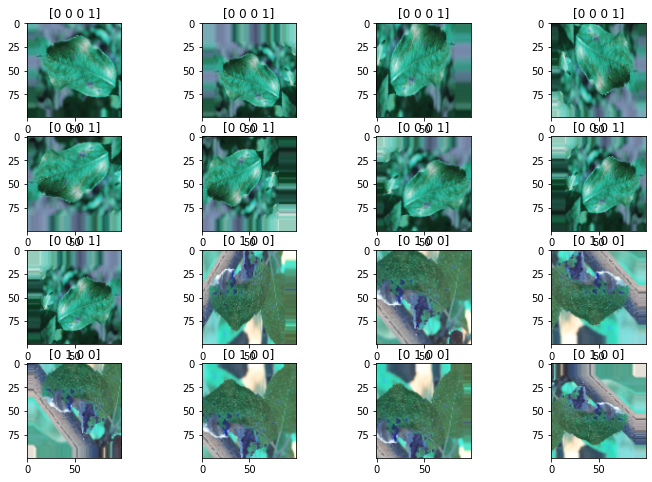

In [15]:
plt.figure(figsize = (12, 8))
for i in range(16):
  plt.subplot(4, 4, i + 1)
  plt.imshow(images[i])
  plt.title(labels[i])
plt.show()

## Build Model

In [16]:

d = tf.keras.applications.DenseNet201(include_top=False,
                   input_shape=(100,100,3),
                   pooling=None,
                   weights='imagenet')
for i in d.layers:
  i.trainable = True


2022-12-02 14:55:44.241624: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 14:55:44.243031: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 14:55:44.432218: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 14:55:44.433504: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 14:55:44.434683: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

74850304/74836368 [==============================] - 0s 0us/step


In [17]:
'''
d = tf.keras.applications.EfficientNetB7(weights='imagenet',
                                                include_top=True, 
                                                input_shape=(600, 600, 3),
                                                drop_connect_rate=0.3)
for i in d.layers:
  i.trainable = True
'''  

"\nd = tf.keras.applications.EfficientNetB7(weights='imagenet',\n                                                include_top=True, \n                                                input_shape=(600, 600, 3),\n                                                drop_connect_rate=0.3)\nfor i in d.layers:\n  i.trainable = True\n"

In [18]:
from keras import regularizers

In [19]:
output_avg = tf.keras.layers.GlobalAveragePooling2D()(d.output)
output_max = tf.keras.layers.GlobalMaxPooling2D()(d.output)
m = tf.keras.layers.minimum([output_avg, output_max])
m = tf.keras.layers.Dropout(0.5)(m)

m = tf.keras.layers.Dense(128, activation = "sigmoid",kernel_regularizer=regularizers.l1(0.0001))(m)
m = tf.keras.layers.Dropout(0.3)(m)
m = tf.keras.layers.Dense(256, activation = "relu",kernel_regularizer=regularizers.l1(0.0001))(m)
m = tf.keras.layers.Dropout(0.3)(m)
m = tf.keras.layers.Dense(512, activation = "relu" ,kernel_regularizer=regularizers.l1(0.0001))(m)
m = tf.keras.layers.Dropout(0.3)(m)
m = tf.keras.layers.Dense(4, activation= "softmax")(m)
m = tf.keras.models.Model(inputs = d.input, outputs = m)
m.compile(optimizer = tf.keras.optimizers.Adam(0.001), 
          loss = "categorical_crossentropy", 
          metrics =["accuracy", 
                     Precision(name='precision'), 
                     Recall(name='recall')])
m.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 106, 106, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 50, 50, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [20]:

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.30, random_state = 42)


## Train Model

In [21]:
history = m.fit(x_train, y_train, epochs = 30, batch_size = 32,
                callbacks = [
                    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, mode = 'min',
                                                  patience= 1),
                    tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3, mode = 'min', restore_best_weights = True)
                ])

2022-12-02 14:55:54.483369: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1376640000 exceeds 10% of free system memory.
2022-12-02 14:55:56.718541: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1376640000 exceeds 10% of free system memory.
2022-12-02 14:55:57.904334: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-12-02 14:56:18.766325: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


359/359 [==============================] - 90s 160ms/step - loss: 1.4544 - accuracy: 0.7523 - precision: 0.8388 - recall: 0.6720
Epoch 2/30
359/359 [==============================] - 55s 152ms/step - loss: 0.7751 - accuracy: 0.8824 - precision: 0.9072 - recall: 0.8559
Epoch 3/30
359/359 [==============================] - 55s 152ms/step - loss: 0.5326 - accuracy: 0.9067 - precision: 0.9267 - recall: 0.8883
Epoch 4/30
359/359 [==============================] - 55s 153ms/step - loss: 0.4409 - accuracy: 0.9147 - precision: 0.9342 - recall: 0.8973
Epoch 5/30
359/359 [==============================] - 54s 151ms/step - loss: 0.3768 - accuracy: 0.9203 - precision: 0.9377 - recall: 0.9044
Epoch 6/30
359/359 [==============================] - 55s 152ms/step - loss: 0.3460 - accuracy: 0.9266 - precision: 0.9409 - recall: 0.9107
Epoch 7/30
359/359 [==============================] - 55s 152ms/step - loss: 0.2953 - accuracy: 0.9394 - precision: 0.9507 - recall: 0.9276
Epoch 8/30
359/359 [===========

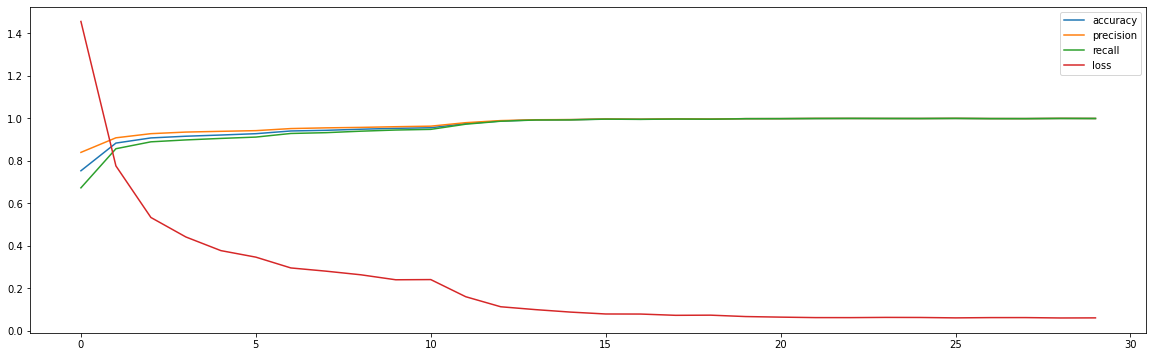

In [22]:
plt.figure(figsize = (20, 6))
plt.plot(history.history['accuracy'], label = "accuracy")
plt.plot(history.history['precision'], label = "precision")
plt.plot(history.history['recall'], label = "recall")
plt.plot(history.history['loss'], label = "loss")
plt.legend()

In [23]:
m.evaluate(x_test, y_test, batch_size= 32)

2022-12-02 15:24:39.136350: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 590040000 exceeds 10% of free system memory.
2022-12-02 15:24:39.842445: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 590040000 exceeds 10% of free system memory.


154/154 [==============================] - 13s 59ms/step - loss: 0.1461 - accuracy: 0.9727 - precision: 0.9739 - recall: 0.9721


[0.14609579741954803,
 0.9727476239204407,
 0.9739201068878174,
 0.9721375107765198]

In [24]:
y_pred = m.predict(x_test)
y_pred = np.argmax(y_pred, axis = 1)

2022-12-02 15:24:54.438732: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 590040000 exceeds 10% of free system memory.


In [25]:
y_test

array([[0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       ...,
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

In [26]:
y_pred

array([3, 3, 2, ..., 0, 0, 0])

In [27]:
y_test = np.argmax(y_test, axis = 1)

In [28]:
cnn_standard_acc = accuracy_score(y_pred, y_test)
print(cnn_standard_acc)

0.9727476103315029


In [29]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1413
           1       0.78      0.86      0.82       227
           2       0.98      0.99      0.99      1650
           3       0.98      0.97      0.97      1627

    accuracy                           0.97      4917
   macro avg       0.93      0.95      0.94      4917
weighted avg       0.97      0.97      0.97      4917



In [30]:
def generate_confusion_matrix(y_pred, y_test):
    c = tf.math.confusion_matrix(y_pred, y_test)
    sns.heatmap(c, annot=True)

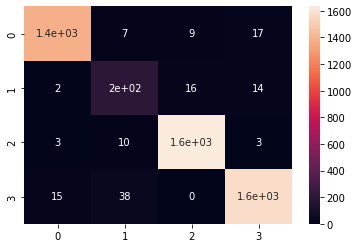

In [31]:
generate_confusion_matrix(y_pred, y_test)

# CNN Features + (RandomForest , XGBOOST, SVM)

## Extract CNN features from CMM pre_traind Model

In [32]:
new_model = tf.keras.models.Model(
    m.input, m.get_layer('minimum').output
)

In [33]:
features_x_train = new_model.predict(x_train)

In [34]:
features_x_test = new_model.predict(x_test)

In [35]:
features_x_train.shape

(11472, 1920)

## Features Engineering by scaling it

In [36]:
scaler = StandardScaler()
scaler.fit(features_x_train)

StandardScaler()

In [37]:
x_tr = scaler.transform(features_x_train)
x_te = scaler.transform(features_x_test)

## XGBClassifier

In [38]:
clf = xgb.XGBClassifier(max_depth = 50, n_estimators = 500)
clf.fit(x_tr, np.argmax(y_train, axis = 1))

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=50, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [39]:
y_pred = clf.predict(x_te)

In [40]:
xgboost_acc = accuracy_score(y_pred, y_test)
print(xgboost_acc)

0.9731543624161074


In [41]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1408
           1       0.76      0.86      0.81       222
           2       0.99      0.98      0.99      1669
           3       0.98      0.97      0.98      1618

    accuracy                           0.97      4917
   macro avg       0.93      0.95      0.94      4917
weighted avg       0.97      0.97      0.97      4917



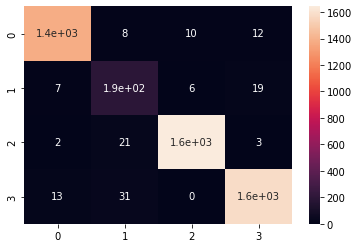

In [42]:
generate_confusion_matrix(y_pred, y_test)

## RandomForestClassifier

In [43]:
clf = RandomForestClassifier(max_depth=50,n_estimators = 500)
clf.fit(x_tr, np.argmax(y_train, axis = 1))
y_pred = clf.predict(x_te)

In [44]:
randomforest_acc = accuracy_score(y_pred, y_test)
print(randomforest_acc)

0.9713239780353874


In [45]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1409
           1       0.78      0.82      0.80       236
           2       0.99      0.99      0.99      1663
           3       0.97      0.97      0.97      1609

    accuracy                           0.97      4917
   macro avg       0.93      0.94      0.93      4917
weighted avg       0.97      0.97      0.97      4917



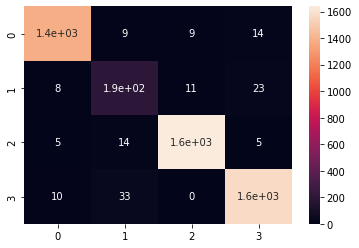

In [46]:
generate_confusion_matrix(y_pred, y_test)

## Support vector machines (SVMs)

In [47]:
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(x_tr, np.argmax(y_train, axis = 1))
y_pred = clf.predict(x_te)

In [48]:
svm_acc = accuracy_score(y_pred, y_test)
print(svm_acc)

0.9735611145007118


In [49]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1412
           1       0.77      0.87      0.82       223
           2       0.99      0.99      0.99      1664
           3       0.98      0.97      0.97      1618

    accuracy                           0.97      4917
   macro avg       0.93      0.95      0.94      4917
weighted avg       0.97      0.97      0.97      4917



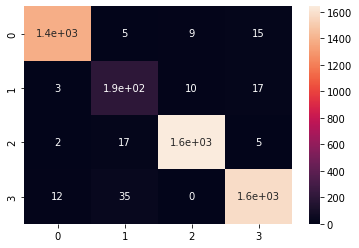

In [50]:
generate_confusion_matrix(y_pred, y_test)

**KNN CLASSIFICATION**

In [51]:
x_train.shape

(11472, 100, 100, 3)

In [52]:
x_test.shape

(4917, 100, 100, 3)

In [53]:
import pandas as pd
  
import numpy as np
  
from sklearn.model_selection import train_test_split
  
from scipy.stats import mode
  
from sklearn.neighbors import KNeighborsClassifier
  
# K Nearest Neighbors Classification
  
class K_Nearest_Neighbors_Classifier() : 
      
    def __init__( self, K ) :
          
        self.K = K
          
    # Function to store training set
          
    def fit( self, X_train, Y_train ) :
          
        self.X_train = X_train
          
        self.Y_train = Y_train
          
        # no_of_training_examples, no_of_features
          
        self.m, self.n, self.o,self.p = X_train.shape
      
    # Function for prediction
          
    def predict( self, X_test ) :
          
        self.X_test = X_test
          
        # no_of_test_examples, no_of_features
          
        self.m_test, self.n, self.o,self.p = X_test.shape
          
        # initialize Y_predict
          
        Y_predict = np.zeros( self.m_test )
          
        for i in range( self.m_test ) :
              
            x = self.X_test[i]
              
            # find the K nearest neighbors from current test example
              
            neighbors = np.zeros( self.K )
              
            neighbors = self.find_neighbors( x )
              
            # most frequent class in K neighbors
              
            Y_predict[i] = mode( neighbors )[0][0]    
              
        return Y_predict
      
    # Function to find the K nearest neighbors to current test example
            
    def find_neighbors( self, x ) :
          
        # calculate all the euclidean distances between current 
        # test example x and training set X_train
          
        euclidean_distances = np.zeros( self.m )
          
        for i in range( self.m ) :
              
            d = self.euclidean( x, self.X_train[i] )
              
            euclidean_distances[i] = d
          
        # sort Y_train according to euclidean_distance_array and 
        # store into Y_train_sorted
          
        inds = euclidean_distances.argsort()
          
        Y_train_sorted = self.Y_train[inds]
          
        return Y_train_sorted[:self.K]
      
    # Function to calculate euclidean distance
              
    def euclidean( self, x, x_train ) :
          
        return np.sqrt( np.sum( np.square( x - x_train ) ) )
  

In [54]:
model = K_Nearest_Neighbors_Classifier( K = 3 )
      
model.fit( x_train, y_train )

In [55]:
#from sklearn.neighbors import KNeighborsClassifier  

In [56]:
'''
classifier= KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2 ) 
classifier.fit(x_tr, np.argmax(y_train, axis = 1))
y_pred = classifier.predict(x_te)
'''

"\nclassifier= KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2 ) \nclassifier.fit(x_tr, np.argmax(y_train, axis = 1))\ny_pred = classifier.predict(x_te)\n"

In [57]:
knn_acc = accuracy_score(y_pred, y_test)
print(knn_acc)

0.9735611145007118


In [58]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1412
           1       0.77      0.87      0.82       223
           2       0.99      0.99      0.99      1664
           3       0.98      0.97      0.97      1618

    accuracy                           0.97      4917
   macro avg       0.93      0.95      0.94      4917
weighted avg       0.97      0.97      0.97      4917



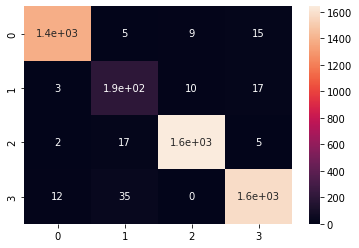

In [59]:
generate_confusion_matrix(y_pred, y_test)

# Final Results

In [60]:
pd.DataFrame({
    "Algorithm": ["DenseNet CNN", "CNN + XGBOOST", "CNN + Random Forest", "CNN + SVM" , "CNN + KNN"],
    "Accuracy for same testing data": [cnn_standard_acc, xgboost_acc, randomforest_acc, svm_acc ,knn_acc ],
}).head()

,Algorithm,Accuracy for same testing data
0,DenseNet CNN,0.972748
1,CNN + XGBOOST,0.973154
2,CNN + Random Forest,0.971324
3,CNN + SVM,0.973561
4,CNN + KNN,0.973561


# Summary
According to the results obtained, neural networks are still able to give better accuracy than the rest of the proposed models.